In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,BatchNormalization,Conv2DTranspose,Concatenate,Reshape,LeakyReLU,Dropout

In [2]:
from google.colab import drive
drive.mount("/gdrive")
%cd /gdrive
import os
os.chdir("/gdrive/My Drive/colab_calisma_ortami")

Mounted at /gdrive
/gdrive


In [3]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [4]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()
x_train=x_train.astype(np.float32)/255
x_test=x_test.astype(np.float32)/255

4422102/4422102 [==============================] - 1s 0us/step


In [5]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

**Generator**

In [6]:
num_features=100
generator=Sequential()

generator.add(Dense(7*7*128,input_shape=[num_features]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64,(5,5),(2,2),padding="same",activation="tanh"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(32,(5,5),padding="same",activation="tanh"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1,(5,5),(2,2),padding="same",activation="tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

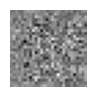

In [7]:
noise=tf.random.normal(shape=[1,num_features])
generated_images=generator(noise,training=False)
show(generated_images,1)

**Discrimination**

In [8]:
discriminator=Sequential()

discriminator.add(Conv2D(64,(5,5),(2,2),activation=LeakyReLU(0.2),padding="same",input_shape=[28,28,1]))
discriminator.add(Dropout(0.2))
discriminator.add(Conv2D(128,(5,5),(2,2),activation=LeakyReLU(0.2),padding="same"))
discriminator.add(Dropout(0.2))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation="sigmoid"))

In [9]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

In [10]:
decision = discriminator(generated_images,training=False)
print(decision)

tf.Tensor([[0.50438404]], shape=(1, 1), dtype=float32)


In [11]:
discriminator.compile(loss="binary_crossentropy",optimizer="adam")
discriminator.trainable=False
gan=Sequential([generator,discriminator])
gan.compile(loss="binary_crossentropy",optimizer="adam")

In [12]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         891265    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1104130 (4.21 MB)
Trainable params: 890817 (3.40 MB)
Non-trainable params: 213313 (833.25 KB)
_________________________________________________________________


In [13]:
from IPython import display
from tqdm import tqdm
seed=tf.random.normal(shape=[batch_size,100])

In [14]:
def generate_and_save_images(model,epoch,test_input):
  predictions=model(test_input,training=False)
  plt.figure(figsize=(8,8))

  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(predictions[i, : , : ,0]*127.5+127.5,cmap="binary")
    plt.axis("off")
  plt.savefig("image_at_epoch_{:04d}.png".format(epoch))

In [21]:
def train_dcgan(gan,dataset,batch_size,num_features,epochs=5):
  generator,discriminator=gan.layers
  for epoch in tqdm(range(epochs)):
    print("Epoch {}/{}".format(epoch+1,epochs))
    for X_batch in dataset:
      noise=tf.random.normal(shape=[batch_size,num_features])
      generated_img=generator(noise)
      y1=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
      X_fake_and_real=tf.concat([generated_img,X_batch],axis=0)
      discriminator.trainable=True
      discriminator.train_on_batch(X_fake_and_real,y1)
      discriminator.trainable=False
      noise=tf.random.normal(shape=[batch_size,num_features])
      y2=tf.constant([[1.]]*batch_size)
      gan.train_on_batch(noise,y2)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [16]:
x_train_dcgan=x_train.reshape(-1,28,28,1) * 2. - 1. #veriyi [-1,1] aralığına alma

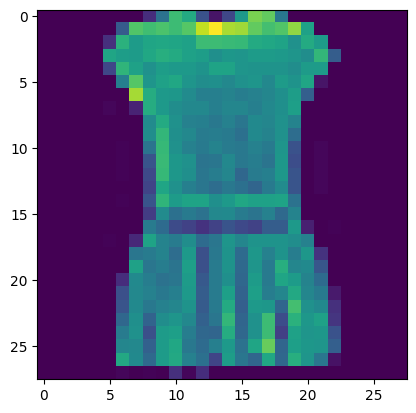

In [17]:
plt.imshow(x_train_dcgan[3])

In [18]:
type(x_train_dcgan)

numpy.ndarray

In [19]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset=dataset.shuffle(1000)
dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

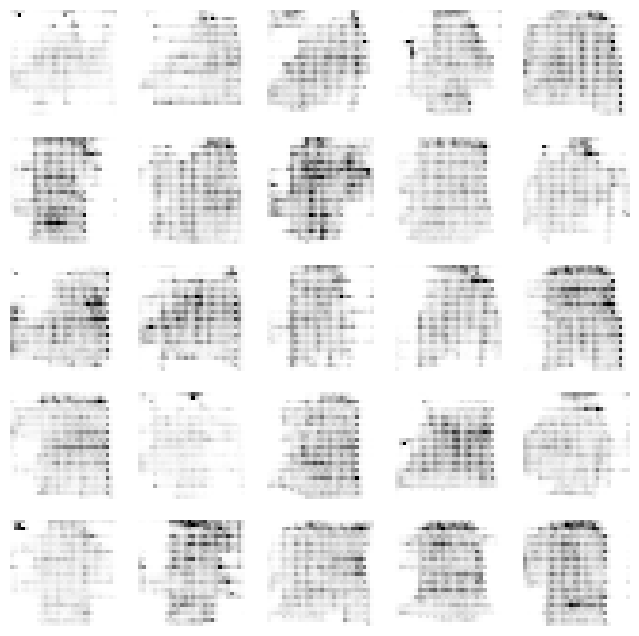

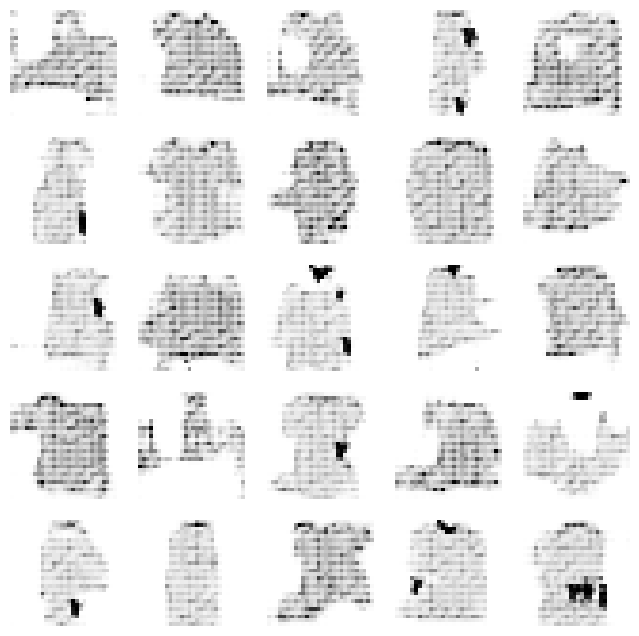

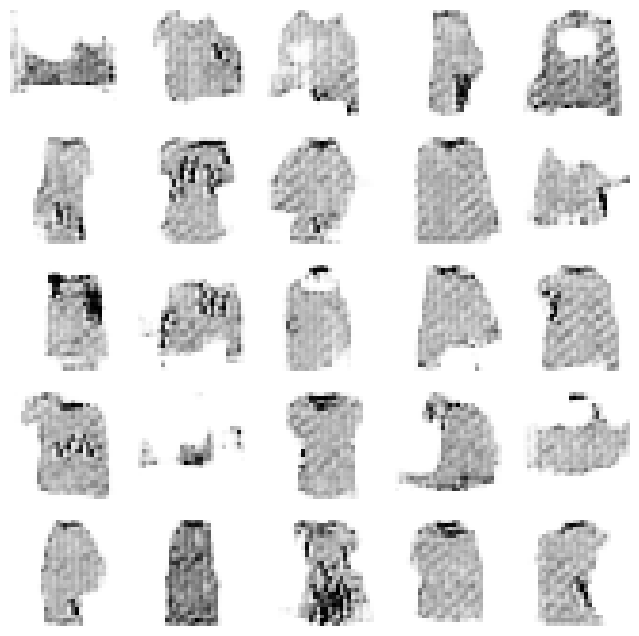

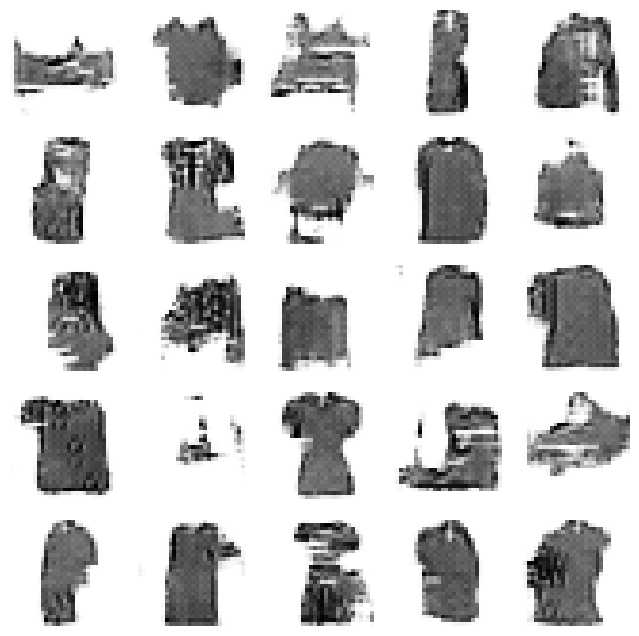

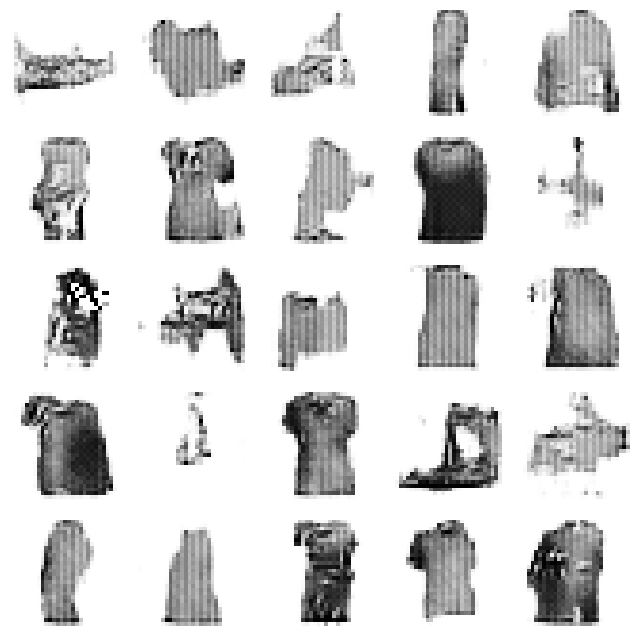

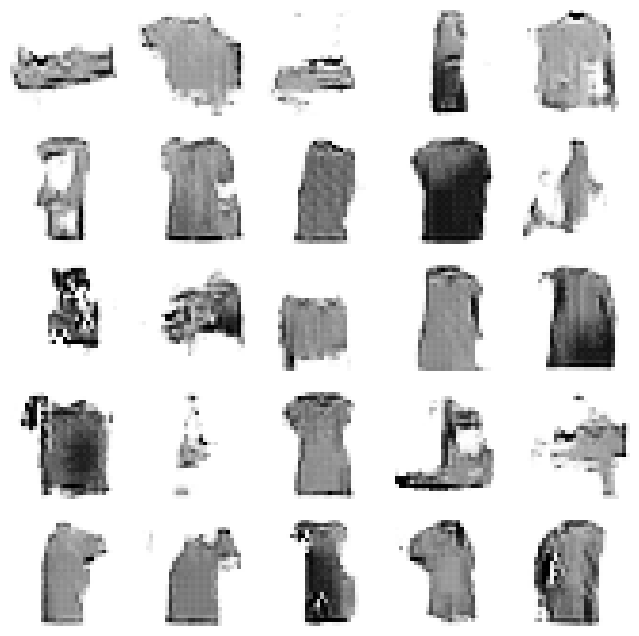

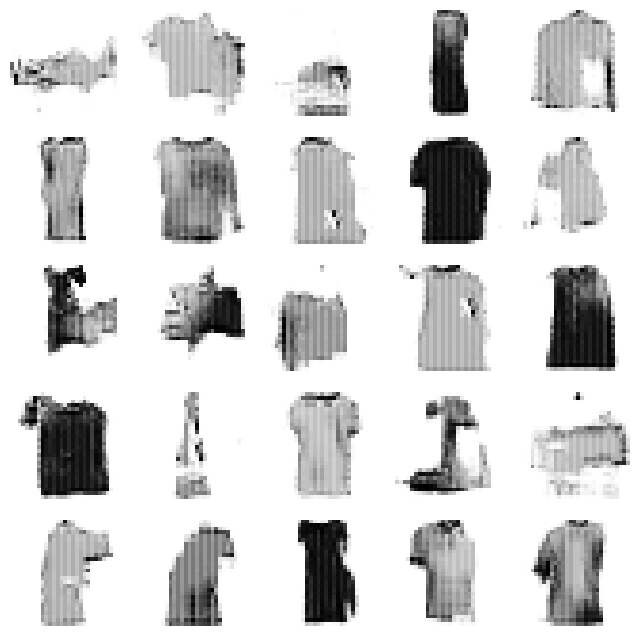

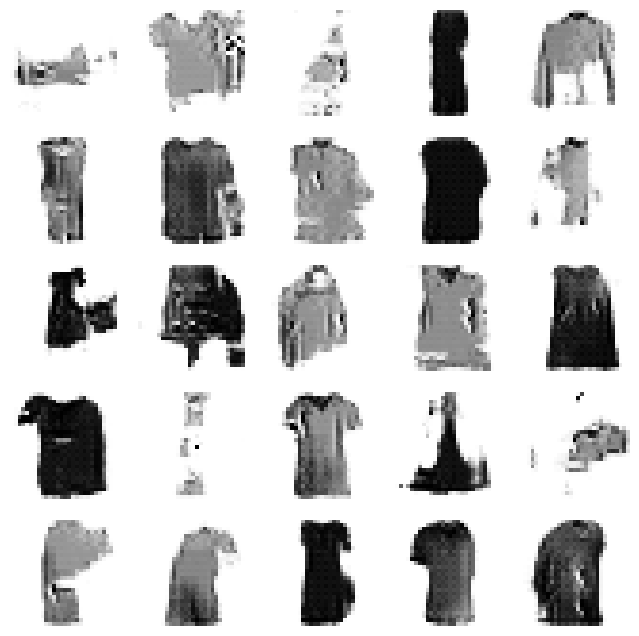

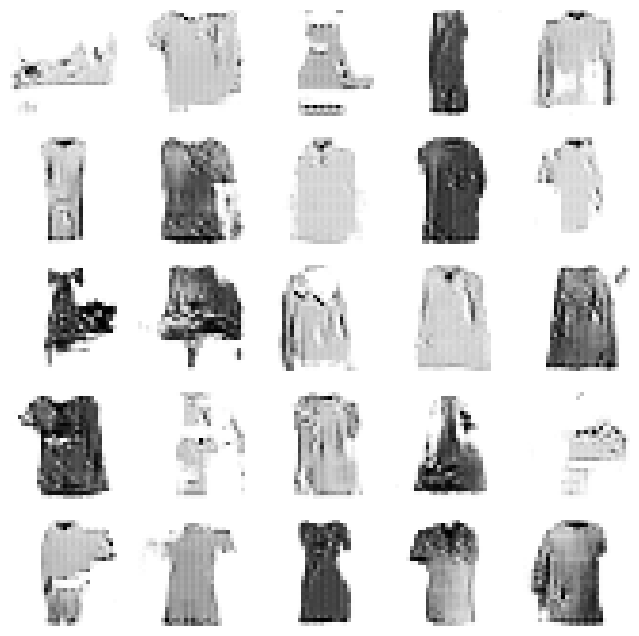

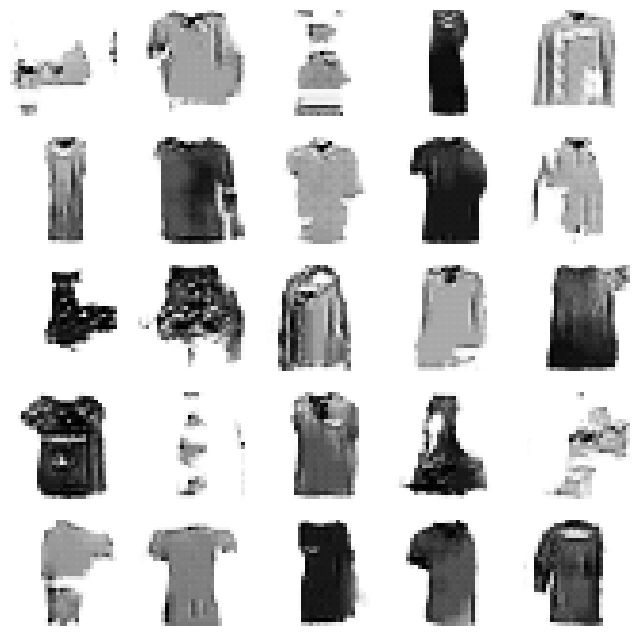

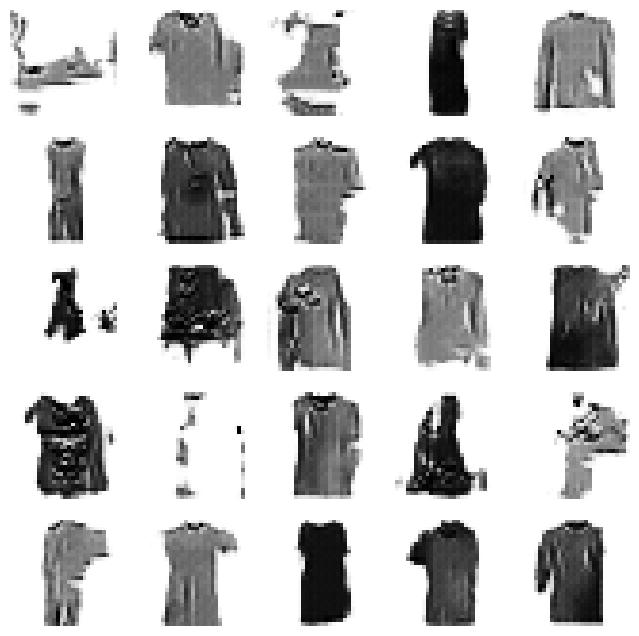

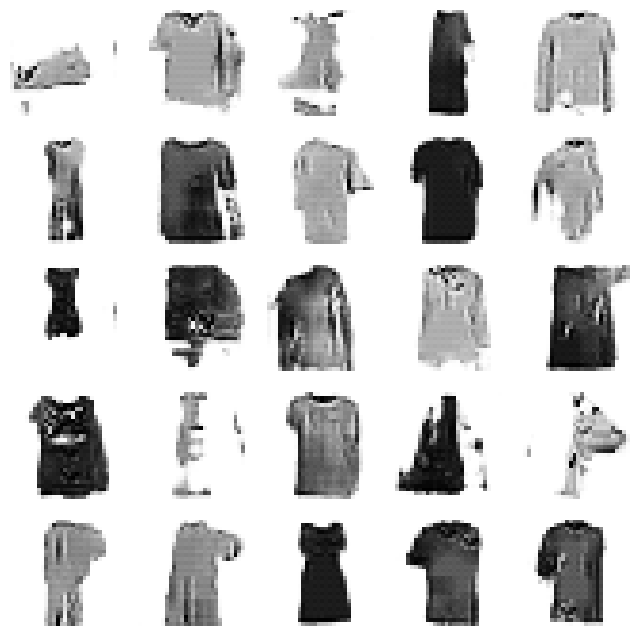

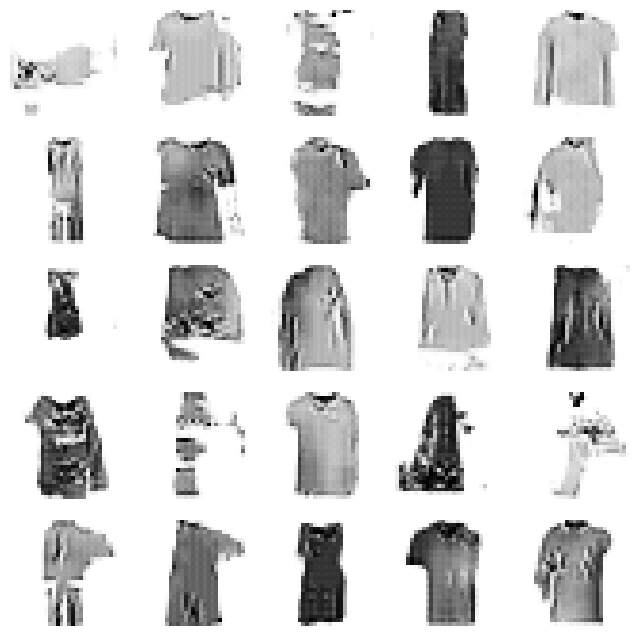

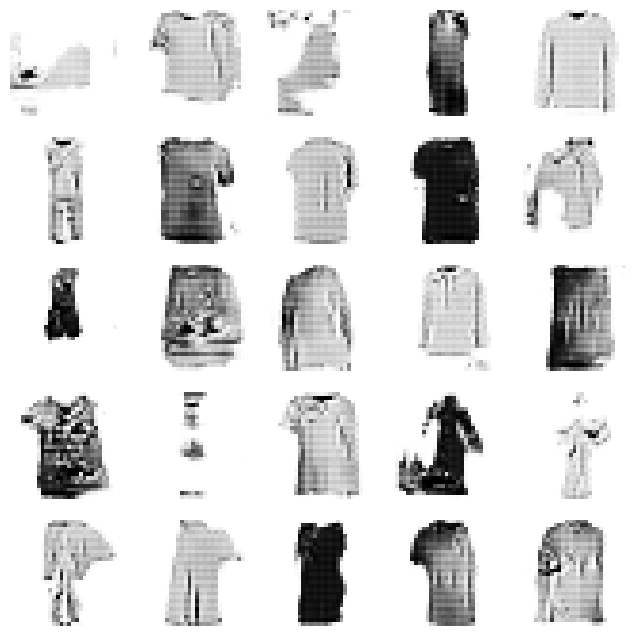

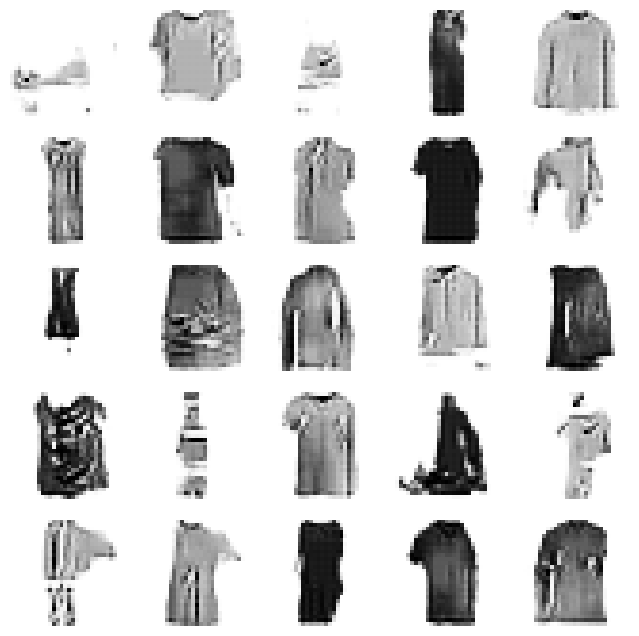

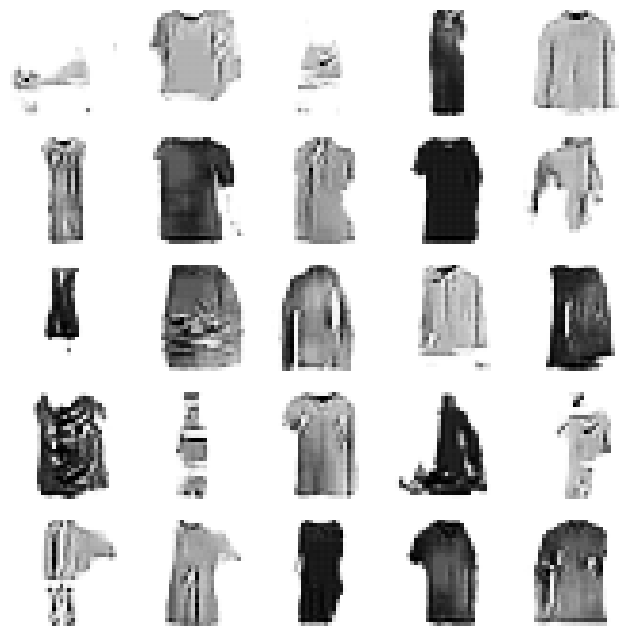

In [22]:
train_dcgan(gan,dataset,batch_size,num_features,epochs=15)

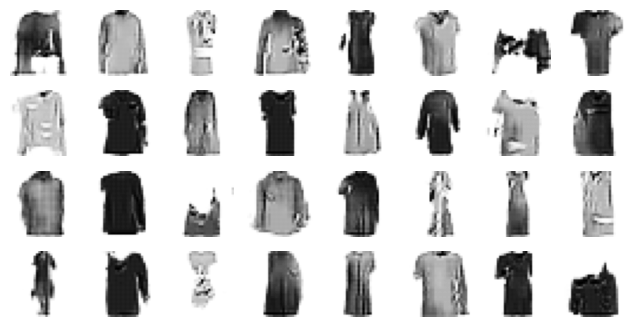

In [23]:
noise=tf.random.normal(shape=[batch_size,num_features])
generated_images=generator(noise)
show(generated_images,8)

In [26]:
#Kaynak GIF: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

from IPython.display import Image
Image(open(anim_file,'rb').read())

<ipython-input-26-dffb73054171>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


FileNotFoundError: No such file: '/gdrive/MyDrive/colab_calisma_ortami/image_at_epoch_0015.png'

In [25]:
generator.save("save_model/gan_generator_15epochs_fashionmnist.h5")
gan.save("save_model/gan_15epochs_fashionmnist.h5")
generator.save("save_model/gan_discriminator_15epochs_fashionmnist.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
